Before loading the images, i must check the dataset for any class imbalances to identify if certain classes are underrepresented or not. If they are, then the model might predict towards more frequently seen classes which would lead to lower accuracy. I will count the number of images in each directory and then visualize this information on a graph.

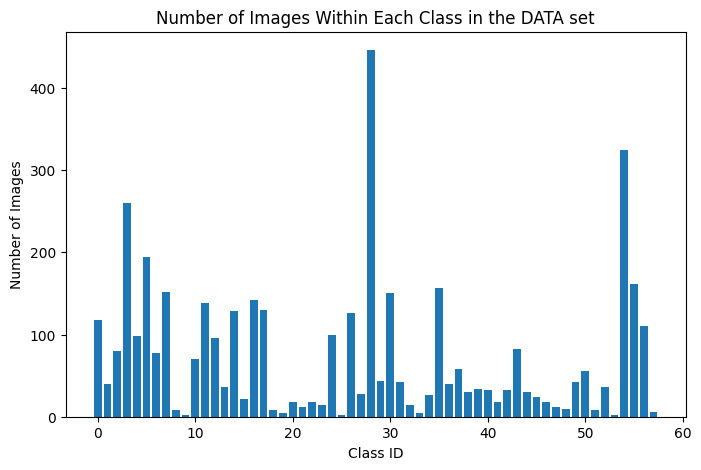

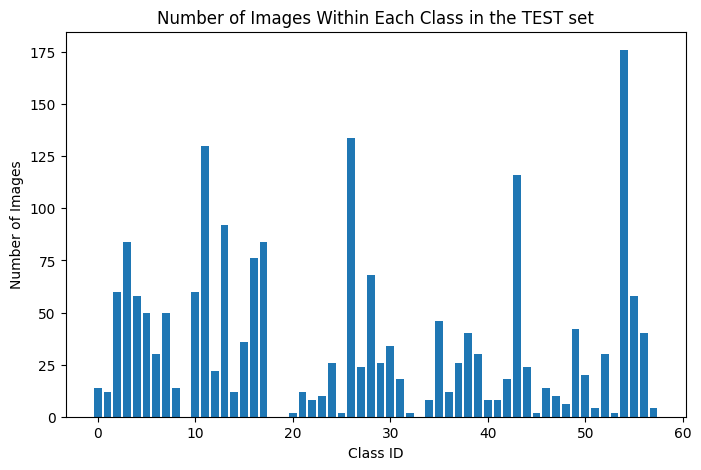

In [2]:
import os

from matplotlib import pyplot as plt

data_path = 'data/traffic_Data/DATA' 
test_path = 'data/traffic_Data/TEST'

# Dictionary storing classes and the amount of images in each class
data_image_counts = {}
for class_id in range(58):
    directory = os.path.join(data_path, str(class_id))
    if os.path.exists(directory):
        data_image_counts[class_id] = len(os.listdir(directory))

test_image_counts = {}
for class_id in range(58):
    directory = os.path.join(test_path, str(class_id))
    if os.path.exists(directory):
        test_image_counts[class_id] = len(os.listdir(directory))
    
# Plotting the data for each class
plt.figure(figsize=(8, 5))
plt.bar(data_image_counts.keys(), data_image_counts.values())
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Number of Images Within Each Class in the DATA set')
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(test_image_counts.keys(), test_image_counts.values())
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Number of Images Within Each Class in the TEST set')
plt.show()

As seen above, the classes in each file have a very uneven distribution, which will have a negative effect on the output and results of the model. 

To prevent the problem, I have firstly set the class weights hyperparameter to be "balanced" within the SVM classifier model, which will make it pay more attention to underrepresented classes by treating their misclassifications as more significant than other classes.

To try and mitigate under-represented classes, I have merged the TEST and DATA so there are more images in each class for training and validation. 
To try and mitigate over-represented classes, I limited the amount of images from each class to 150, so certain outliers don't skew the model training.

Before loading in the images, I want to verify that each image (in both the test set and data set) is a valid input to the SVM classifier model and is readable.
I will use Pillow (PIL) to handle the images.

In [ ]:
import os
from PIL import Image

labels_path = 'data/labels.csv'

# Verifying the images in the DATA set

valid_data_images = []
for class_id in range(58):
    directory = os.path.join(data_path, str(class_id))
    if os.path.exists(directory):
        for img_file in os.listdir(directory):
            try:
                image = Image.open(os.path.join(directory, img_file))
                image.verify()
                valid_data_images.append(os.path.join(directory, img_file))
            except Exception as e:
                print(f"Image not valid: {img_file}, Error: {e}")

# Verifying the images in the TEST set

valid_test_images = []
for class_id in range(58):
    directory = os.path.join(test_path, str(class_id))
    if os.path.exists(directory):
        for img_file in os.listdir(directory):
            try:
                image = Image.open(os.path.join(directory, img_file))
                image.verify()
                valid_test_images.append(os.path.join(directory, img_file))
            except Exception as e:
                print(f"Image not valid: {img_file}, Error: {e}")

print("All images successfully verified.")          

All images successfully verified.


The images must be loaded from the directories, and then pre-processed so they can be fed into the SVM classifier.
I will pre-process each image and load it in with it's corresponding ClassId.
The labels for the dataset are loaded in as a dataframe from the csv file.
I have chosen to combine the DATA and TEST sets and do the pre-processing steps together for both, and limited the class images to 150 as mentioned previously.

I have also chosen to resize each image to 32x32 and turn it into greyscale to process less features, this reduces memory usage and speeds up training (and still leaves enough features for the model to effectivley distinguish classes). The images are flattened aswell as the SVM model expects a 2D array as input.

In [4]:
import os
import cv2
import numpy as np
import pandas as pd

images = []
class_ids = []
labels = pd.read_csv(labels_path)

for class_id in range(58):
    data_directory = os.path.join(data_path, str(class_id))
    test_directory = os.path.join(test_path, str(class_id))
    
    class_img_count = 0
    
    if os.path.exists(data_directory):
        for img_file in os.listdir(data_directory):
            if class_img_count >= 150:
                break
            img_path = os.path.join(data_directory, img_file)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (32, 32)) # Resize
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Greyscale
            image = image.flatten() # Flatten
            images.append(image)
            class_ids.append(class_id)
            class_img_count += 1
    
    if os.path.exists(test_directory):
        for img_file in os.listdir(test_directory):
            if class_img_count >= 150:
                break
            img_path = os.path.join(test_directory, img_file)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (32, 32)) # Resize
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Greyscale
            image = image.flatten() # Flatten
            images.append(image)
            class_ids.append(class_id)
            class_img_count += 1
    
# Define X (input data) and y (target data) as numpy arrays
X = np.array(images) / 255.0
y = np.array(class_ids)

print(f"Total images loaded: {len(images)}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Total images loaded: 4540
Shape of X: (4540, 1024)
Shape of y: (4540,)


Let's view some of the images with their corresponding labels to visualise the data that we are feeding into the model.

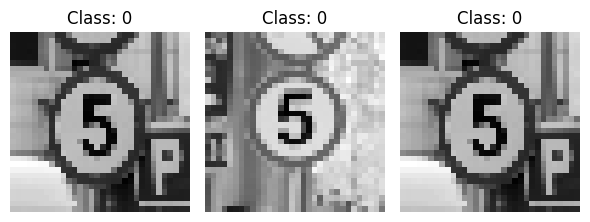

In [5]:
def plot_samples(images, class_ids, n_rows=1, n_cols=3):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(32, 32), cmap='gray')
        ax.set_title(f"Class: {class_ids[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(X[:3], y[:3])

After some data pre-processing, I will establish a baseline Support Vector Machine classifier model to build off of, and analyse the effect of changing hyperparameters one-by-one (proceeding on the best validation accuracy for each) to eventually reach a refined SVM model that is fully tuned.

I will use 80% of the dataset for training and a 5 fold cross-validation, and the rest of the 20% I will keep as a holdout test set to test the model on completely unseen data once the optimizations and tuning have been applied:

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f"Shape of X_trainval: {X_trainval.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_trainval: (3178, 1024)
Shape of X_test: (1362, 1024)


Then I fit the model and record baseline cross-validation scores, and a baseline mean cross-validation accuracy:

In [53]:
from sklearn.model_selection import cross_val_score

svc = SVC(kernel="rbf", C=1, random_state=42)

# Perform 5-fold cross-validation on preprocessed data
cv_scores = cross_val_score(svc, X_trainval, y_trainval, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.79716981 0.77830189 0.79559748 0.8015748  0.77165354]
Mean Cross-Validation Accuracy: 0.7889


I would first like to normalize the features using StandardScaler to make sure every feature contributes equally by standardizing their magnitudes, which in turn should lead to better accuracy and convergence. I will re-evaluate the model's scores after scaling the data: 

In [54]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_trainval)

# Perform 5-fold cross-validation on preprocessed data
cv_scores = cross_val_score(svc, X_scaled, y_trainval, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.80503145 0.77830189 0.79402516 0.80314961 0.77795276]
Mean Cross-Validation Accuracy: 0.7917


The model had training time didn't change significantly, and the mean CV accuracy improved from 0.7889 to 0.7917 - which is a very slight improvement.

Next, I apply Principle Component Analysis (PCA) to extract the most meaningful features by keeping the principle components that capture the most variance. This makes the SVM model a lot faster to train and more computationally efficient without a significant loss in accuracy.

I have used the method outlined in the PCA tutorial to plot cumulative variance against the number of components, to visualise and determine the minimum amount of principle components to use.
It seems like 250 components capture around 95% of the variance, which is sufficient.

I re-evaluated the model after this change aswell:

/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


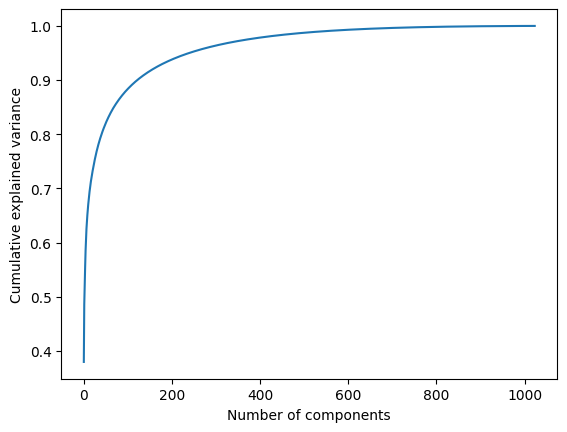

In [55]:
from sklearn.decomposition import PCA

pca_test = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

pca = PCA(n_components=250)
X_pca = pca.fit_transform(X_scaled)

cv_scores = cross_val_score(svc, X_pca, y_trainval, cv=5, scoring='accuracy')

The training time for 5 fold cross validaiton was reduced from 21 to 12 seconds, which shows that the model training time nearly halved in duration which is great.

Now I will test 4 different kernels for the SVM classifier model by looping through each type and recording the cross-val scores for each to determine the best option:

In [57]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

results=[]

for kernel in kernels:
    svc = SVC(kernel=kernel, C=1, random_state=42)
    
    cv_scores = cross_val_score(svc, X_pca, y_trainval, cv=5, scoring='accuracy')
    
    results.append((kernel, cv_scores, cv_scores.mean()))

for result in results:
    print(f"Kernel: {result[0]} CV_score: {result[1]} CV_score mean: {result[2]}")

/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Kernel: linear CV_score: [0.90566038 0.8836478  0.89779874 0.90866142 0.89133858] CV_score mean: 0.8974213836477988
Kernel: rbf CV_score: [0.79716981 0.78144654 0.7908805  0.7984252  0.77480315] CV_score mean: 0.788545040360521
Kernel: poly CV_score: [0.53459119 0.57075472 0.57389937 0.58897638 0.55590551] CV_score mean: 0.5648254345565296
Kernel: sigmoid CV_score: [0.34433962 0.3836478  0.3836478  0.36377953 0.37637795] CV_score mean: 0.3703585400881494


From the results it is clear that a "linear" kernel is much more suited for the model than the baseline "rbf" kernel, yielding a 0.897 mean CV score on the linear kernel. Poly and sigmoid kernels however proved to be bad choices, with mean CV scores of 0.564 and 0.370 respectfully.

Next I would like to tune the "C" hyperparameter in the SVM model. 
The C value controls the trade-off between maximizing the margin and minimizing the classification error.
- High C value = model will aim to classify as many points correctly as possible, penalizing misclassifications heavily (risk of overfitting)
- Low C value = model allows more misclassifications to maintain a larger margin (focusing more on general patterns, risk of underfitting)

I will test with a series of "C" values ranging from 0.001 to 1000:

In [58]:
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

results = []

for c_value in c_values:
    svc = SVC(kernel="linear", C=c_value, random_state=42)
    
    cv_scores = cross_val_score(svc, X_pca, y_trainval, cv=5, scoring='accuracy')
    
    results.append((c_value, cv_scores, cv_scores.mean()))

for result in results:
    print(f"C Value: {result[0]} CV_score: {result[1]} CV_score mean: {result[2]}")

/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:77

C Value: 0.001 CV_score: [0.7327044  0.7091195  0.75471698 0.71338583 0.72913386] CV_score mean: 0.7278121131085029
C Value: 0.01 CV_score: [0.89937107 0.87264151 0.87421384 0.88188976 0.88503937] CV_score mean: 0.8826311097905215
C Value: 0.1 CV_score: [0.90566038 0.88207547 0.89622642 0.90708661 0.88976378] CV_score mean: 0.8961625315703461
C Value: 1 CV_score: [0.90566038 0.8836478  0.89779874 0.90866142 0.89133858] CV_score mean: 0.8974213836477988
C Value: 10 CV_score: [0.90566038 0.8836478  0.89779874 0.90866142 0.89133858] CV_score mean: 0.8974213836477988
C Value: 100 CV_score: [0.90566038 0.8836478  0.89779874 0.90866142 0.89133858] CV_score mean: 0.8974213836477988
C Value: 1000 CV_score: [0.90566038 0.8836478  0.89779874 0.90866142 0.89133858] CV_score mean: 0.8974213836477988


It is clear that the CV score mean plateaus at around 0.1 C value and does not achieve a better mean after that. This is the sweetspot for this hyperparameter as a simpler model is produced that is less prone to overfitting, so this value will be used.

As mentioned in the pre-processing, I will also set the class_weight parameter to "balanced" in an attempt to smooth out class imbalances further by adding more weighting to under-represented classes and less to over-represented classes, balancing them. I will re-evaluate the model after to observe if this has any effect on the CV scoring:

In [59]:
svc_improved = SVC(kernel="linear", C=0.1, class_weight="balanced", random_state=42)

cv_scores = cross_val_score(svc, X_pca, y_trainval, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.90566038 0.8836478  0.89779874 0.90866142 0.89133858]
Mean Cross-Validation Accuracy: 0.8974


This didn't affect the model's CV scores with it remaining around 0.897, but decreases the training time to 7 seconds.

Now that we have acheived a significant reduction in training time (roughly 21s -> 7s) and also a reasonable increase in CV scores and mean CV score (roughly 0.788 -> 0.897), we can bring back the holdout test set and test the model on fresh unseen data to evaluate generalisation.

I will first need to scale and apply PCA to the test features just like the trainval features:

In [61]:
X_test_scaled = scaler.fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)

cv_scores = cross_val_score(svc_improved, X_test_pca, y_test, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

/Users/yarikkrasnov/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.75457875 0.75091575 0.78676471 0.78308824 0.75      ]
Mean Cross-Validation Accuracy: 0.7651


After all the modifications and tuning we reach a mean CV score for the holdout set of 0.759, proving that the model generalises fairly well to new data.